### Begin by importing the necessary modules and functions.

In [1]:
import astropy.io.fits as fits
import astropy.units as u
from astropy.convolution import convolve, convolve_fft, convolve_models, Kernel, Kernel2D
import os
import numpy as np
import time
from pathlib import Path
home_path = Path(os.getcwd())

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})

from importlib import reload
import misc_functions
reload(misc_functions)
from misc_functions import mask_im, apply_det

lambda0_m = 575e-9
D = 2.3631
mas_per_lamD = lambda0_m * 360.0 * 3600.0 / (2 * np.pi * D) * 1000    # mas per lambda0/D
as_per_lamD = mas_per_lamD/1000

nzodi = 256
nprop = 256
nipac = 128

ipac_pxscl_lamD = 0.2
prop_pxscl_lamD = 0.1

ipac_pxscl_mas = ipac_pxscl_lamD*mas_per_lamD # define the different pixelscale
prop_pxscl_mas = prop_pxscl_lamD*mas_per_lamD

sim_exmax = (nipac/2)*ipac_pxscl_lamD # define extent of simulation figures in lamD
sim_extent = [-sim_exmax,sim_exmax,-sim_exmax,sim_exmax]

## Load in a zodiacal scene from the datacube of masked scenes. Choose which incliniation is desired.

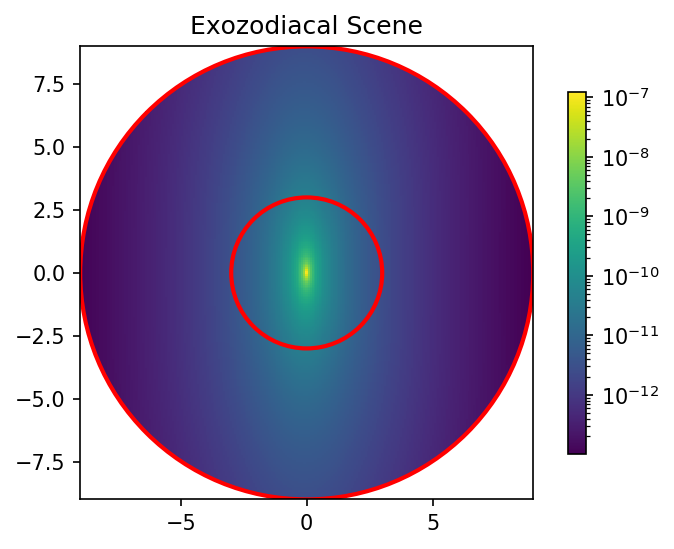

In [21]:
zodinum = 28 # choose which scene within the datacube you want to use, different inclination for the scenes
zodi_fname = 'zodipic_icube_10pc03.529mas_masked.fits'
zodi_path = home_path/'zodi_scenes'/zodi_fname

zodi_cube = fits.getdata(zodi_path)
zodi_cube_header = fits.getheader(zodi_path)
zodi_pxscl = zodi_cube_header['PIXELSCL']*u.arcsec # pixel scale is 3.529

start = 0
stop = 31
step = 1
incs = np.arange(start,stop+step,step)/stop*90 # generate array of inclinations within the zodiacal scenes file
zodi = zodi_cube[zodinum,:,:]

zodi_pixscale = 3.529
xpix,ypix = np.meshgrid(np.arange(-nzodi/2,nzodi/2),np.arange(-nzodi/2,nzodi/2)) # 256by256 grid
x = (xpix+.5).flatten()*zodi_pixscale
y = (ypix+.5).flatten()*zodi_pixscale

# creating the outer mask
inner_mask_radius_mas = 3*mas_per_lamD
index = zodi < zodi.max()/1e32
index[(np.sqrt((x)**2 + (y)**2)<inner_mask_radius_mas).reshape([nzodi,nzodi])]=True
zodi_masked = np.ma.masked_array(zodi, index)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150 )

exmax = (nzodi/2)*zodi_pxscl.value/as_per_lamD # define extent in lamD
exmin = -exmax
zodi_extent = [exmin,exmax,exmin,exmax]

im = ax.imshow(zodi, norm=LogNorm(), cmap=plt.get_cmap('viridis'), extent=zodi_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax.add_patch(circ_in)
ax.add_patch(circ_out)
ax.set_title('Exozodiacal Scene'.format(incs[zodinum]), fontsize=12)
fig.colorbar(im, ax=ax, shrink=0.8) 

## Load one of the offset PSFs to be used for convolution.

zoom: 2.8443904706171352
(364, 364)
(256, 256)


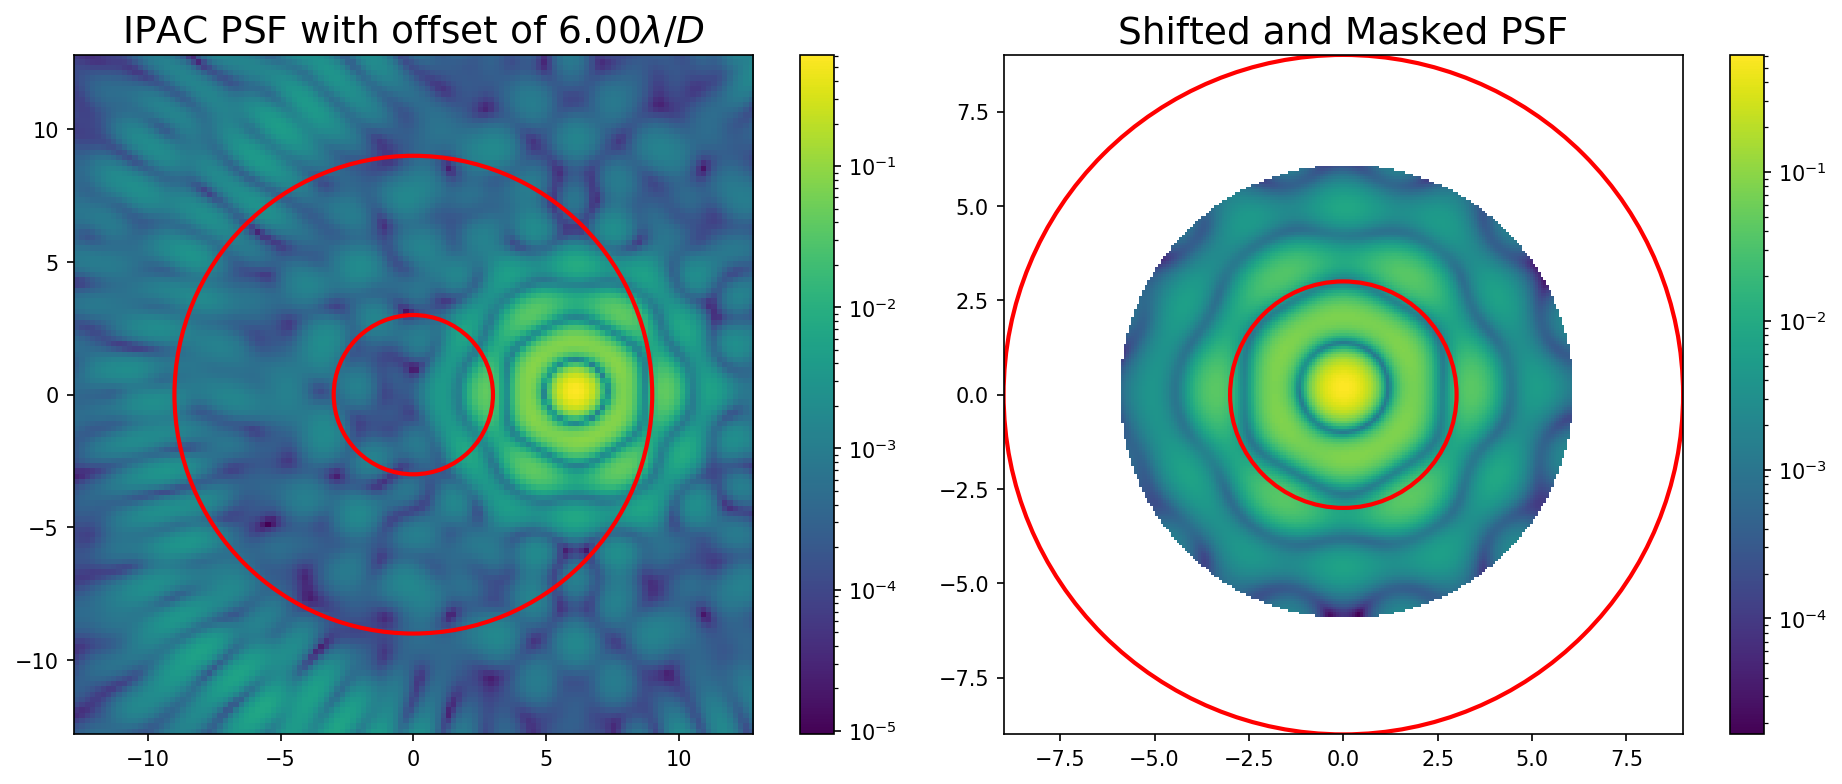

In [3]:
# start with the ipac psfs
ipac_psfs_file_path = home_path/'offset_psfs'/'IPAC_HLC_PSFs'/'20180718_hlc_nfov_PSFs_1Dcube.fits'
ipac_psfs = fits.getdata(ipac_psfs_file_path)
ipac_psfs = np.moveaxis(ipac_psfs,0,-1) # shift the axis of the datacube such that the final entry is the psf number

# get the offset sampling of the ipac psfs from the info file
ipac_info_file_path = home_path/'offset_psfs'/'IPAC_HLC_PSFs'/'20180718_hlc_nfov_PSFs_1Dcube_info.fits'
ipac_offsets = fits.getdata(ipac_info_file_path)
offsets_lamD_ipac = ipac_offsets[:,1]
psfnum = 70
psf = ipac_psfs[:,:,psfnum]

psf_zoomed, psf_zoomed_trim = apply_det(psf, 
                                        ps_det=zodi_pxscl/u.pixel,
                                        ps_input=ipac_pxscl_mas/1000*u.arcsec/u.pixel, 
                                        det_shape=(nzodi,nzodi),
                                        verbose=True) 
print(psf_zoomed.shape)
npsf = psf_zoomed.shape[0]

psf_shifted = np.zeros(shape=(npsf,npsf))
psf_shifted[:,8:275] = psf_zoomed[:,96:363]

xpix,ypix = np.meshgrid(np.arange(-npsf/2,npsf/2),np.arange(-npsf/2,npsf/2)) # 256by256 grid
x = (xpix+.5).flatten()*zodi_pixscale/mas_per_lamD
y = (ypix+.5).flatten()*zodi_pixscale/mas_per_lamD

# creating the mask
mask_radius_mas = 6
index = psf_zoomed < psf_zoomed.max()/1e32
index[(np.sqrt((x)**2 + (y)**2)>mask_radius_mas).reshape([psf_zoomed.shape[0],psf_zoomed.shape[0]])]=True
psf_masked = np.ma.masked_array(psf_shifted, index)

psf_trimmed = psf_masked[53:309,53:309] # make the arry be 256 by 256 for convolution
print(psf_trimmed.shape)
ipac_psf_kernel = Kernel(psf_trimmed) # define the kernel for convolution

figwidth = 16
figheight = 6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(figwidth,figheight), dpi = 150 )
cbar_size = 1
fontsz = 18

im = ax[0].imshow(psf, norm=LogNorm(), cmap=plt.get_cmap('viridis'), extent=sim_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax[0].add_patch(circ_in)
ax[0].add_patch(circ_out)
ax[0].set_title('IPAC PSF with offset of {:.2f}$\lambda/D$'.format(offsets_lamD_ipac[psfnum]), fontsize=fontsz)
fig.colorbar(im, ax=ax[0], shrink=cbar_size) 

im = ax[1].imshow(psf_trimmed, norm=LogNorm(), cmap=plt.get_cmap('viridis'), extent=zodi_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax[1].add_patch(circ_in)
ax[1].add_patch(circ_out)
ax[1].set_title('Shifted and Masked PSF'.format(offsets_lamD_ipac[psfnum]), fontsize=fontsz)
fig.colorbar(im, ax=ax[1], shrink=cbar_size)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)

## Use the astropy convolution function in order to generate simulations and compare.

Simulation with convolution done in 0.05s.
Simulation with convolution done in 0.05s.


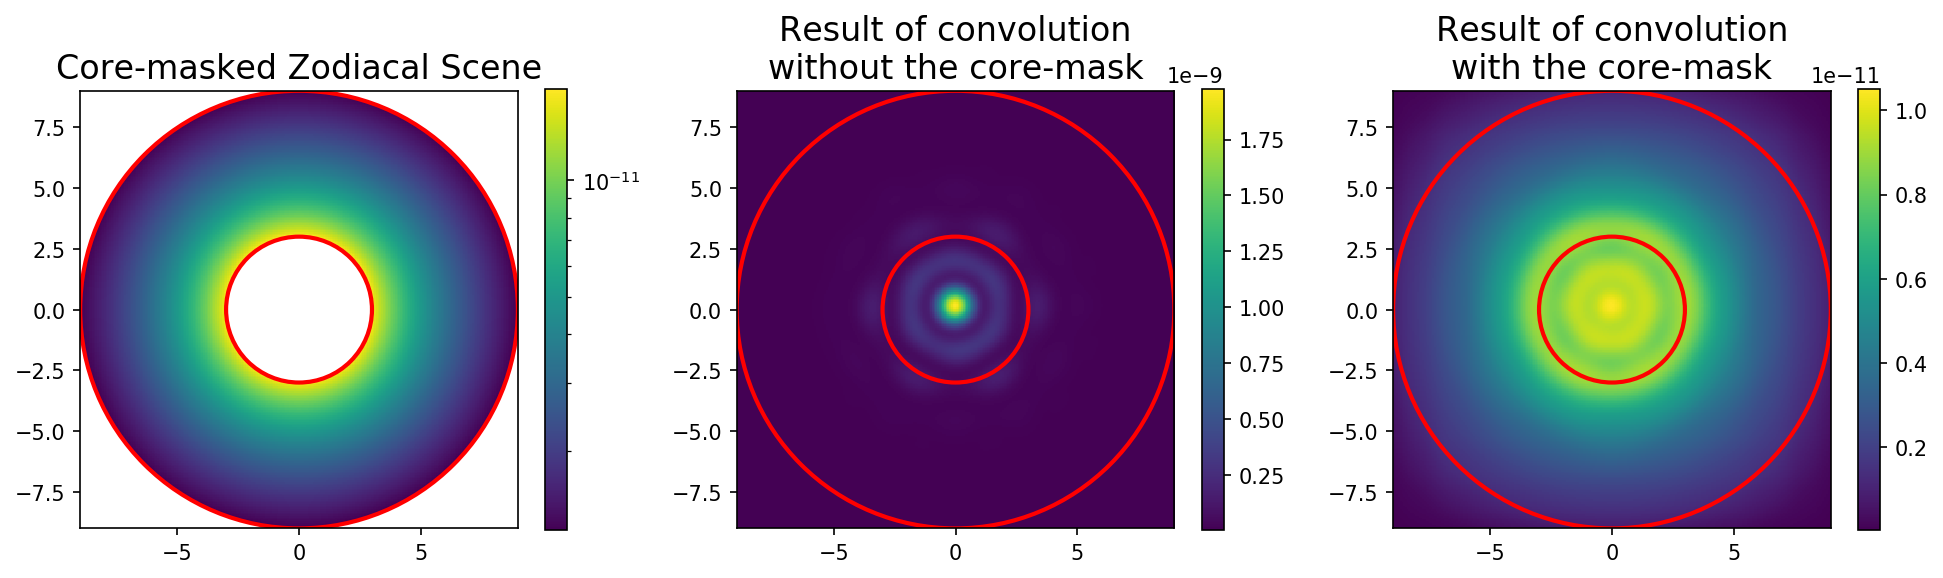

In [18]:
start=time.time()
sim_no_cm = convolve_fft(zodi,ipac_psf_kernel)
end=time.time()
print('Simulation with convolution done in {:.2f}s.'.format(end-start))

start=time.time()
sim_cm = convolve_fft(zodi_masked,ipac_psf_kernel)
end=time.time()
print('Simulation with convolution done in {:.2f}s.'.format(end-start))

figwidth = 16
figheight = 6
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(figwidth,figheight), dpi = 150 )
cbar_size = 0.65
fontsz = 16

im = ax[0].imshow(zodi_masked, norm=LogNorm(), cmap=plt.get_cmap('viridis'), extent=zodi_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax[0].add_patch(circ_in)
ax[0].add_patch(circ_out)
ax[0].set_title('Core-masked Zodiacal Scene', fontsize=fontsz)
fig.colorbar(im, ax=ax[0], shrink=cbar_size) 

im = ax[1].imshow(sim_no_cm, cmap=plt.get_cmap('viridis'), extent=zodi_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax[1].add_patch(circ_in)
ax[1].add_patch(circ_out)
ax[1].set_title('Result of convolution\nwithout the core-mask', fontsize=fontsz)
fig.colorbar(im, ax=ax[1], shrink=cbar_size)

im = ax[2].imshow(sim_cm, cmap=plt.get_cmap('viridis'), extent=zodi_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax[2].add_patch(circ_in)
ax[2].add_patch(circ_out)
ax[2].set_title('Result of convolution\nwith the core-mask', fontsize=fontsz)
fig.colorbar(im, ax=ax[2], shrink=cbar_size)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)


## Now do the same with a disk with different inclination.

Simulation with convolution done in 0.05s.


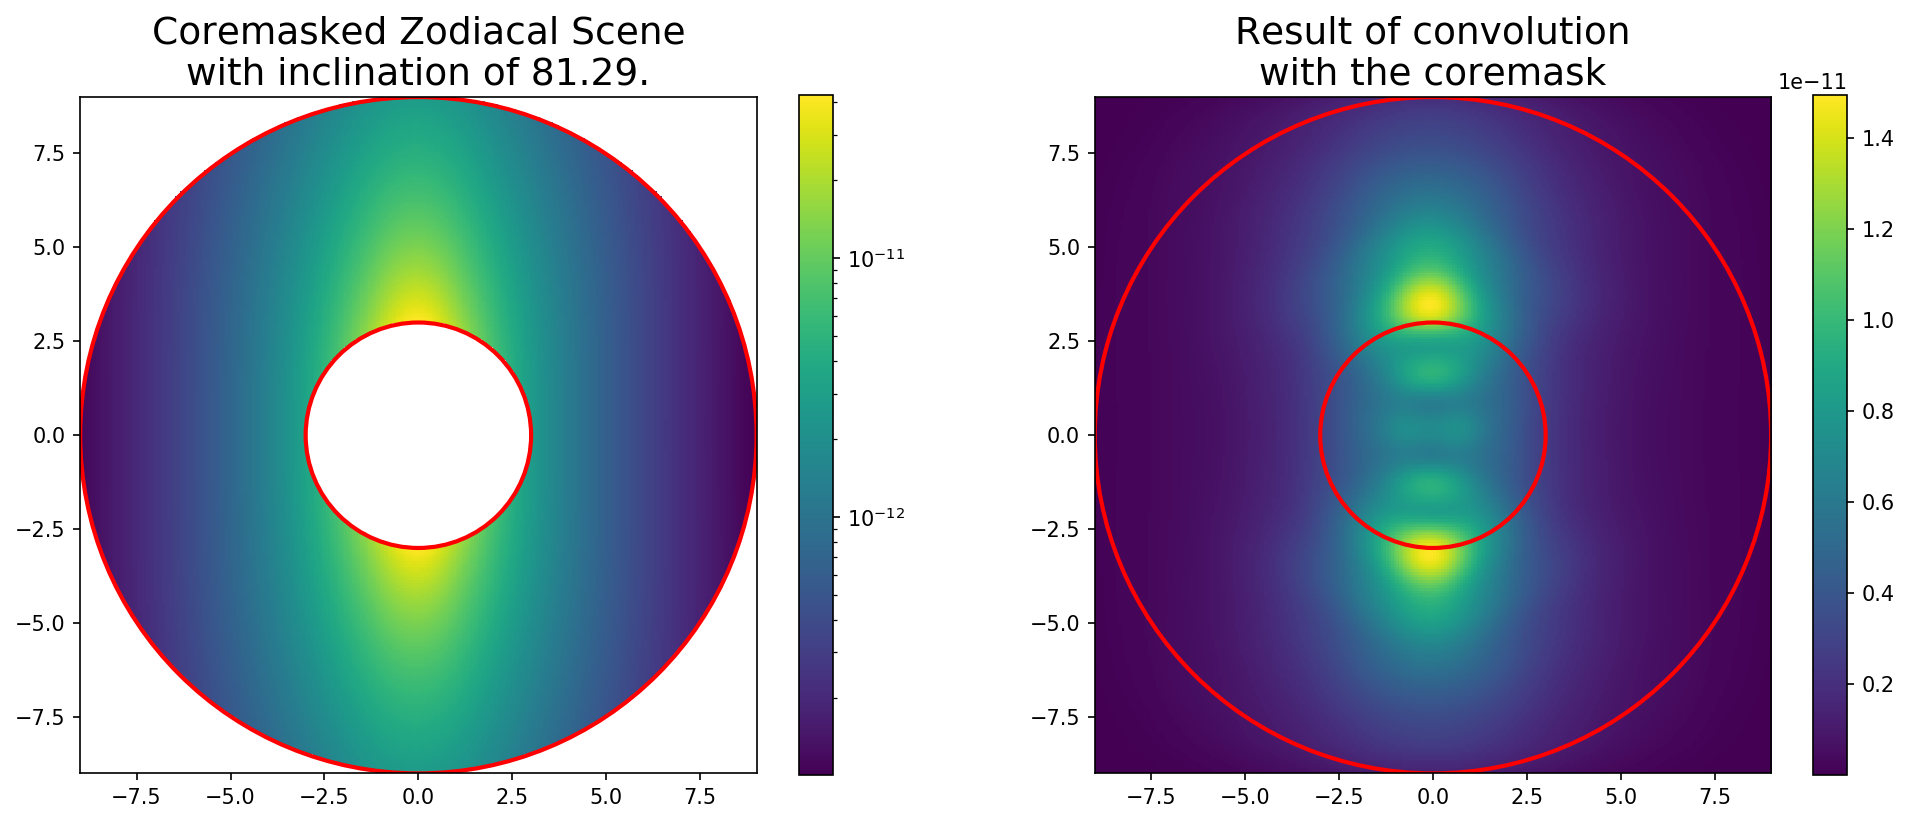

In [12]:
zodinum = 28 # choose which scene within the datacube you want to use, different inclination for the scenes
zodi_fname = 'zodipic_icube_10pc03.529mas_masked.fits'
zodi_path = home_path/'zodi_scenes'/zodi_fname

zodi_cube = fits.getdata(zodi_path)
zodi_cube_header = fits.getheader(zodi_path)
zodi_pxscl = zodi_cube_header['PIXELSCL']*u.arcsec # pixel scale is 3.529

start = 0
stop = 31
step = 1
incs = np.arange(start,stop+step,step)/stop*90 # generate array of inclinations within the zodiacal scenes file
zodi = zodi_cube[zodinum,:,:]

zodi_pixscale = 3.529
xpix,ypix = np.meshgrid(np.arange(-nzodi/2,nzodi/2),np.arange(-nzodi/2,nzodi/2)) # 256by256 grid
x = (xpix+.5).flatten()*zodi_pixscale
y = (ypix+.5).flatten()*zodi_pixscale

# creating the outer mask
inner_mask_radius_mas = 3*mas_per_lamD
index = zodi < zodi.max()/1e32
index[(np.sqrt((x)**2 + (y)**2)<inner_mask_radius_mas).reshape([nzodi,nzodi])]=True
zodi_masked = np.ma.masked_array(zodi, index)

start=time.time()
sim_cm = convolve_fft(zodi_masked,ipac_psf_kernel)
end=time.time()

print('Simulation with convolution done in {:.2f}s.'.format(end-start))

figwidth = 16
figheight = 6
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(figwidth,figheight), dpi = 150 )
cbar_size = 1
fontsz = 18

im = ax[0].imshow(zodi_masked, norm=LogNorm(), cmap=plt.get_cmap('viridis'), extent=zodi_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax[0].add_patch(circ_in)
ax[0].add_patch(circ_out)
ax[0].set_title('Coremasked Zodiacal Scene\nwith inclination of {:.2f}.'.format(incs[zodinum]), fontsize=fontsz)
fig.colorbar(im, ax=ax[0], shrink=cbar_size) 

im = ax[1].imshow(sim_cm, cmap=plt.get_cmap('viridis'), extent=zodi_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax[1].add_patch(circ_in)
ax[1].add_patch(circ_out)
ax[1].set_title('Result of convolution\nwith the coremask', fontsize=fontsz)
fig.colorbar(im, ax=ax[1], shrink=cbar_size)